基于CMIM-GIEF算法的紧凑关联识别案例

In [1]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import sys
import os

BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), "../" * 1))
sys.path.insert(0, BASE_DIR)

from setting import plt
from giefstat.compact_recog import CondMIMaximization, recog_compact

Use environmental variables in default.yml


载入待分析数据, 总样本量为2727，其中X为217个过程变量数据, Y为四个收率（轻柴油、重柴油、汽油、干气）的数据：

In [2]:
X_df = pd.read_csv(f"{BASE_DIR}/dataset/fcc/X.csv")
Y_df = pd.read_csv(f"{BASE_DIR}/dataset/fcc/Y.csv")

In [3]:
print(X_df.shape)
print(Y_df.shape)

(2727, 217)
(2727, 4)


#### **情形1：已选特征集X_pre为空时的紧凑变量选择**

In [4]:
# 候选特征和已选特征
X_pre, X_cand = None, X_df.values[:, 20:]

# 目标为轻柴油收率
y = Y_df.values[:, 0]

# 紧凑关联排序
if X_pre is None:
    X = X_cand
    S_pre = set()
else:
    X = np.c_[X_pre, X_cand]  # NOTE: 按照已选和候选先后顺序拼合为一个数组
    S_pre = set(range(X_pre.shape[1]))
    
self = CondMIMaximization(X, y)
features_rank, _ = self.feature_selection(S_pre, verbose=True)

# FIMT测试并截断
metric="r2"
model = RandomForestRegressor(
    n_estimators=100, 
    max_features="auto",  # NOTE: 这里选用"auto"使用全部特征建模是为了避免过拟合, 但是计算量会比选择"sqrt"更大
    min_samples_leaf=3,
    min_samples_split=10,
    n_jobs = 3)
n_features_lst = np.arange(1, len(features_rank) + 1, 1)  # 依次递增的测试特征数

features_compact, fimt_values = recog_compact(
    X, y, features_rank, model, n_features_lst, S_pre, metric, rounds=3)

iteration i=0 	 select feature no. 31
iteration i=1 	 select feature no. 169
iteration i=2 	 select feature no. 52
iteration i=3 	 select feature no. 138
iteration i=4 	 select feature no. 185
iteration i=5 	 select feature no. 173
iteration i=6 	 select feature no. 180
iteration i=7 	 select feature no. 137
iteration i=8 	 select feature no. 183
iteration i=9 	 select feature no. 111
iteration i=10 	 select feature no. 154
iteration i=11 	 select feature no. 152
iteration i=12 	 select feature no. 49
iteration i=13 	 select feature no. 158
iteration i=14 	 select feature no. 172
iteration i=15 	 select feature no. 108
iteration i=16 	 select feature no. 113
iteration i=17 	 select feature no. 134
iteration i=18 	 select feature no. 194
iteration i=19 	 select feature no. 5
iteration i=20 	 select feature no. 124
iteration i=21 	 select feature no. 87
iteration i=22 	 select feature no. 133
iteration i=23 	 select feature no. 192
iteration i=24 	 select feature no. 25
iteration i=25 	 

In [5]:
features_compact

[31, 169, 52, 138, 185, 173]

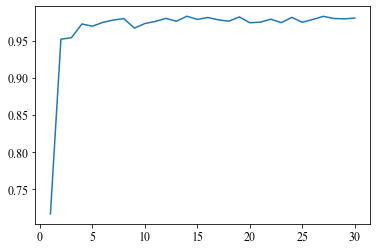

In [6]:
plt.plot(n_features_lst, fimt_values)

In [12]:
np.max(fimt_values)

0.9868218414928333

可见，CMIM-GIEF结合FIMT从217个特征中选出了6个特征，将预测准确度提升至0.98附近。

#### **情形2：已选特征集X_pre不为空时的紧凑变量选择**

首先, 指定本案例中的已选特征、候选特征和目标。其中，设置前10个特征为已选中的紧凑变量，算法需要在剩下的第20个特征以后构成的X_cand中选出额外的紧凑变量。

In [7]:
# 候选特征和已选特征
X_pre, X_cand = X_df.values[:, :10], X_df.values[:, 20:]

# 目标为轻柴油收率
y = Y_df.values[:, 0]

紧凑关联识别, 提供特征排序表：

In [8]:
if X_pre is None:
    X = X_cand
    S_pre = set()
else:
    X = np.c_[X_pre, X_cand]  # NOTE: 按照已选和候选先后顺序拼合为一个数组
    S_pre = set(range(X_pre.shape[1]))
    
self = CondMIMaximization(X, y)
features_rank, _ = self.feature_selection(S_pre, verbose=True)

iteration i=0 	 select feature no. 201
iteration i=1 	 select feature no. 179
iteration i=2 	 select feature no. 184
iteration i=3 	 select feature no. 62
iteration i=4 	 select feature no. 122
iteration i=5 	 select feature no. 119
iteration i=6 	 select feature no. 193
iteration i=7 	 select feature no. 97
iteration i=8 	 select feature no. 162
iteration i=9 	 select feature no. 134
iteration i=10 	 select feature no. 204
iteration i=11 	 select feature no. 183
iteration i=12 	 select feature no. 139
iteration i=13 	 select feature no. 147
iteration i=14 	 select feature no. 41
iteration i=15 	 select feature no. 190
iteration i=16 	 select feature no. 148
iteration i=17 	 select feature no. 202
iteration i=18 	 select feature no. 144
iteration i=19 	 select feature no. 121
iteration i=20 	 select feature no. 195
iteration i=21 	 select feature no. 192
iteration i=22 	 select feature no. 106
iteration i=23 	 select feature no. 164
iteration i=24 	 select feature no. 123
iteration i=2

FIMT测试确定截断：

In [9]:
metric="r2"
model = RandomForestRegressor(
    n_estimators=100, 
    max_features="auto",  # NOTE: 这里选用"auto"使用全部特征建模是为了避免过拟合, 但是计算量会比选择"sqrt"更大
    min_samples_leaf=3,
    min_samples_split=10,
    n_jobs = 3)
n_features_lst = np.arange(1, len(features_rank) + 1, 1)  # 依次递增的测试特征数

features_compact, fimt_values = recog_compact(
    X, y, features_rank, model, n_features_lst, S_pre, metric, rounds=3)

In [10]:
features_compact

[201, 179, 184, 62]

绘制FIMT分数随着CMIM-GIEF所得紧凑变量排序表增长的变化情况：

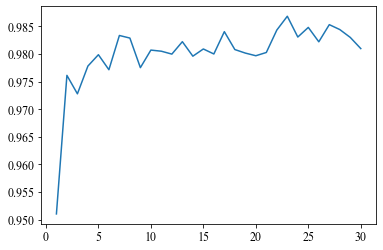

In [11]:
plt.plot(n_features_lst, fimt_values)

可见, CMIM-GIEF结合FIMT测试在X_pre中事先确定的10个特征的基础上额外选择了features_compact中的4个特征, 对应模型分数从0.95上升至0.975附近。

对比情形1和情形2的结果可见, 二者所得降维预测准确度相当，但前者使用特征数为6而后者为 10 + 4 = 14，这说明后者降维特征集中仍含有目标的冗余特征，X_pre是随意指定的，可能并不紧凑。